# Eggbox

This is a simple interactive version of the Eggbox demo in the documentation.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(5)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

The "Eggbox" likelihood is a helpful case that demonstrate Nested Sampling's ability to properly sample/integrate over multi-modal distributions.

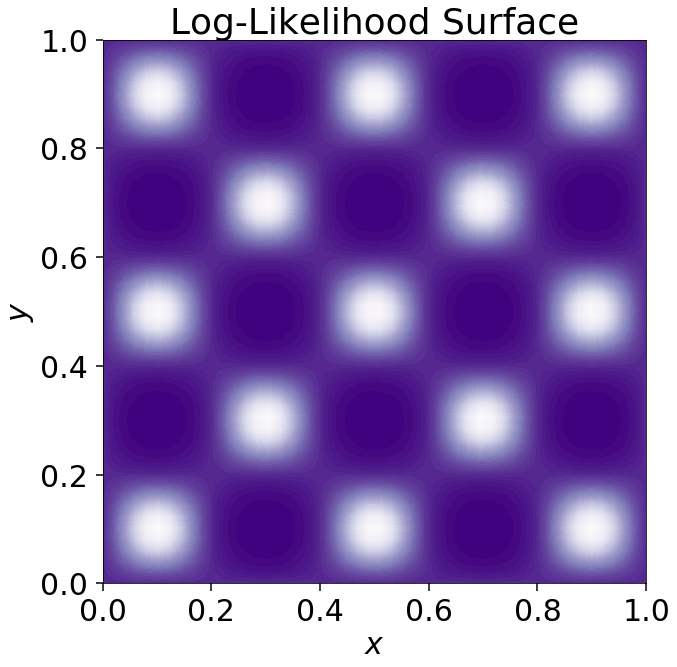

In [4]:
# define the eggbox log-likelihood
tmax = 5.0 * np.pi
def loglike(x):
    t = 2.0 * tmax * x - tmax
    return (2.0 + np.cos(t[0] / 2.0) * np.cos(t[1] / 2.0)) ** 5.0

# define the prior transform
def prior_transform(x):
    return x

# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 50),
                     np.linspace(0., 1., 50))
L = loglike(np.array([xx, yy]))
axes.contourf(xx, yy, L, 50, cmap=plt.cm.Purples_r)
plt.title('Log-Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# ln(evidence)
lnz_truth = 235.88

Let's sample from this distribution using multi-ellipsoidal decomposition.

In [5]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2,
                                        bound='multi', sample='unif',
                                        bootstrap=0)

Let's first start by sampling with a focus on deriving the evidence.

In [6]:
dsampler.run_nested(dlogz_init=0.01, nlive_init=200, nlive_batch=200,
                    wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})
dres_z = dsampler.results

iter: 7262 | batch: 3 | bound: 55 | nc: 1 | ncall: 36646 | eff(%): 19.817 | loglstar:   -inf < 242.998 < 242.068 | logz: 235.942 +/-  0.100 | stop:  1.165                     


Now let's add samples with a focus on deriving the posterior.

In [7]:
dsampler.reset()
dsampler.run_nested(dlogz_init=0.01, nlive_init=200, nlive_batch=200, 
                    wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
dres_p = dsampler.results

iter: 15678 | batch: 21 | bound: 207 | nc: 1 | ncall: 38024 | eff(%): 41.232 | loglstar: 237.173 < 242.998 < 242.602 | logz: 236.008 +/-  0.175 | stop:  1.413                 


Finally, let's switch to using `'balls'`.

In [8]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2,
                                        bound='balls', sample='unif')
dsampler.run_nested(dlogz_init=0.01, nlive_init=200, nlive_batch=200,
                    wt_kwargs={'pfrac': 0.0}, stop_kwargs={'pfrac': 0.0})
dres_z2 = dsampler.results

iter: 11857 | batch: 6 | bound: 194 | nc: 1 | ncall: 81549 | eff(%): 14.540 | loglstar:   -inf < 242.998 < 241.408 | logz: 235.940 +/-  0.071 | stop:  1.093                    


Let's see how we did.

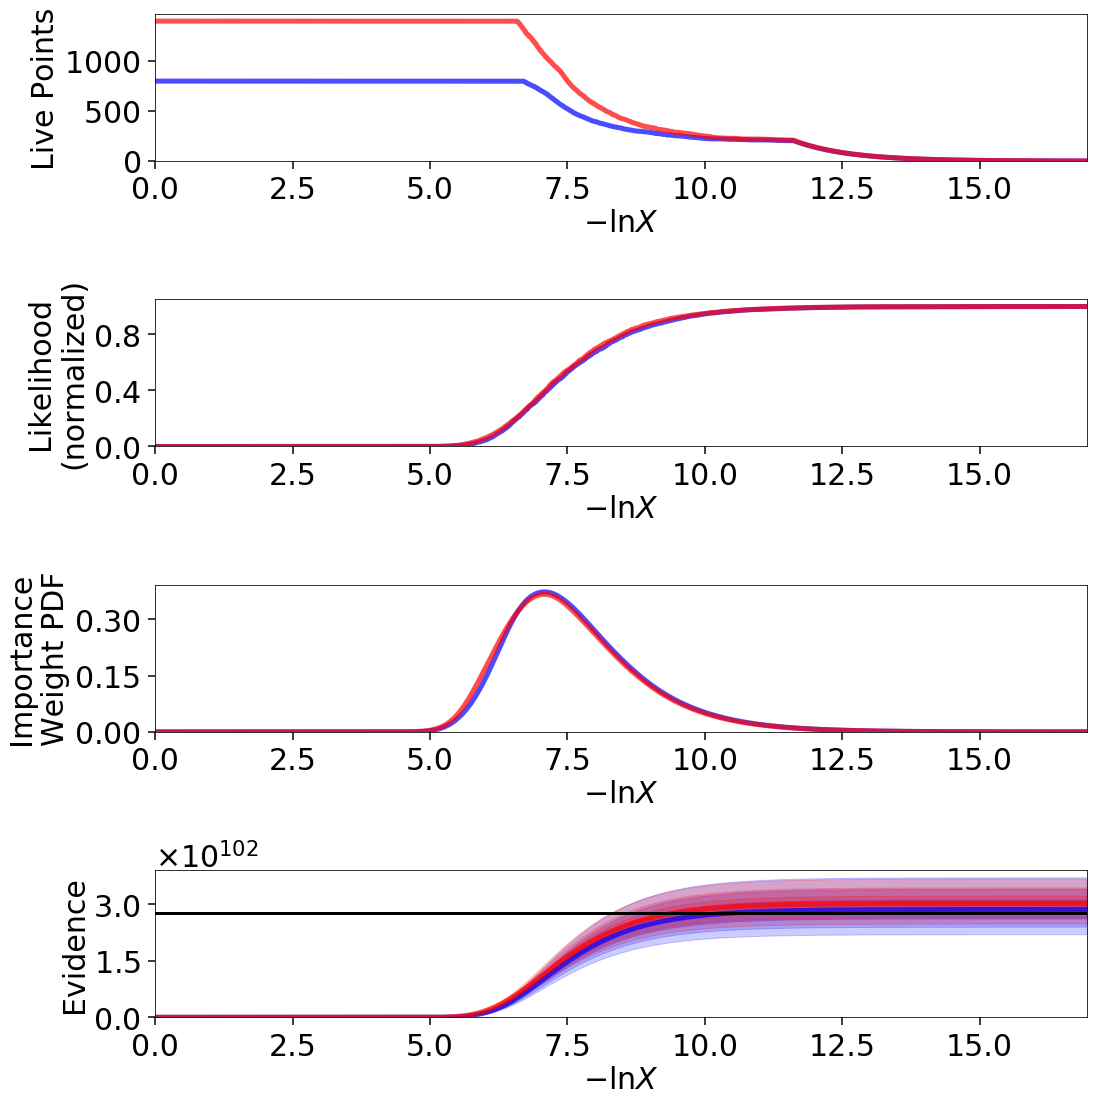

In [9]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(dres_z, color='blue')
fig, axes = dyplot.runplot(dres_z2, color='red', lnz_truth=lnz_truth,
                           truth_color='black', fig=(fig, axes))
fig.tight_layout()

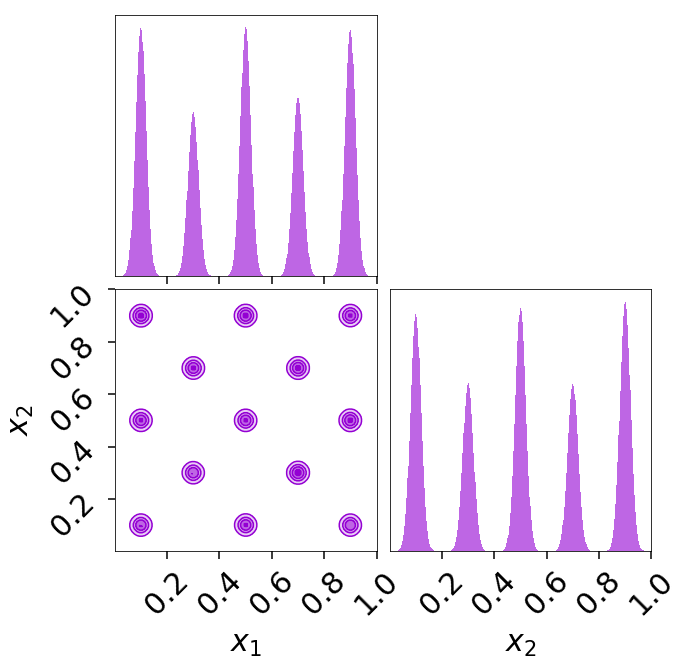

In [10]:
fig, axes = dyplot.cornerplot(dres_p, quantiles=None, color='darkviolet',
                              span=[[0, 1], [0, 1]],
                              fig=plt.subplots(2, 2, figsize=(10, 10)))